In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as  xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")



In [279]:
#read file
df = pd.read_csv("total_frequency_bydate.csv")
#set data as index
df = df.set_index("date")
#convert date to date type
df.index = pd.to_datetime(df.index)

In [280]:
df.head()

,Frequency
date,
2016-01-01,561
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345


<function matplotlib.pyplot.show(close=None, block=None)>

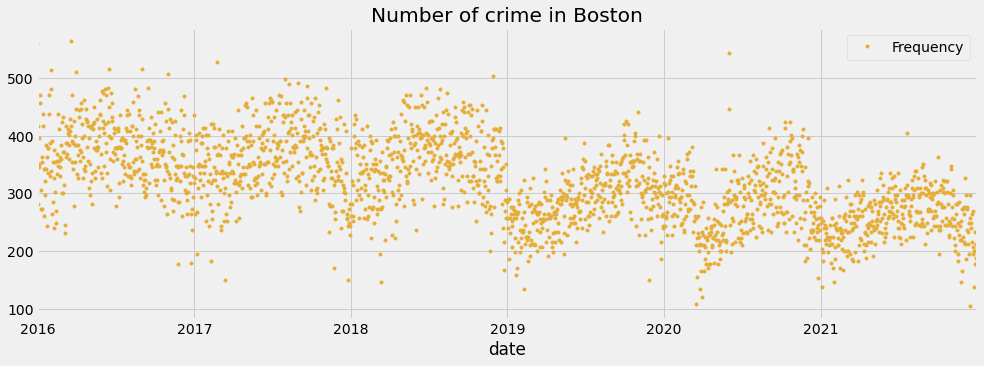

In [281]:
#visualize the data
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[2],
        title="Number of crime in Boston")
plt.show

<AxesSubplot:ylabel='Frequency'>

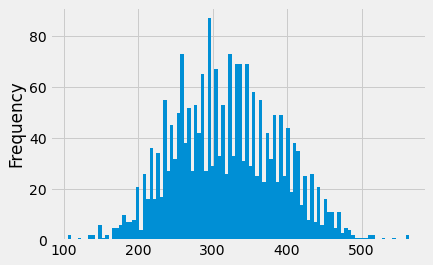

In [282]:
#outlier analysis and removal
#histogram
df['Frequency'].plot(kind="hist",bins=100)

<AxesSubplot:xlabel='date'>

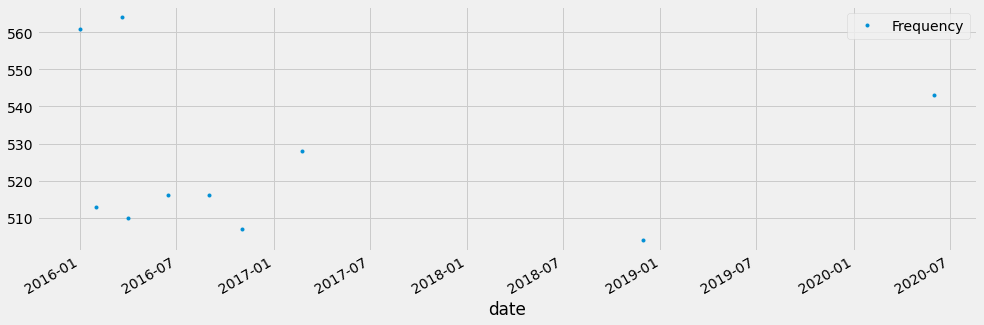

In [283]:
df.query('Frequency >500').plot(figsize=(15,5),style=".")

<AxesSubplot:xlabel='date'>

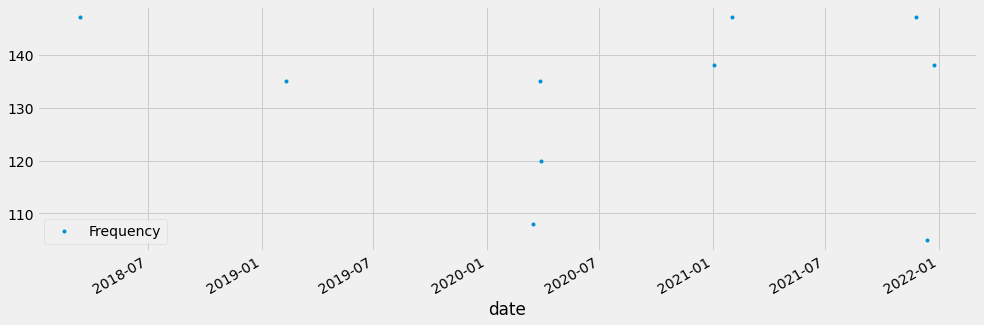

In [284]:
df.query('Frequency < 150').plot(figsize=(15,5),style=".")

In [285]:
#remove outlier
df = df.query('Frequency > 150' and 'Frequency < 500')

df

,Frequency
date,
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345
2016-01-06,396
...,...
2021-12-27,234
2021-12-28,213
2021-12-29,201


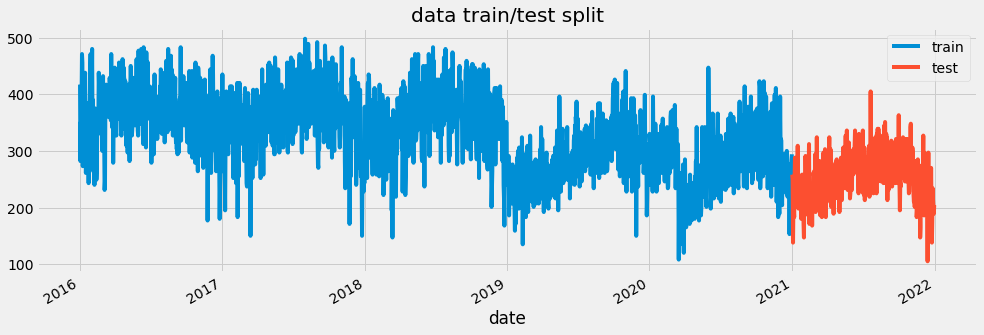

In [286]:
#train test split
train = df.loc[df.index<'01-01-2021']
test = df.loc[df.index>='01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",title='data train/test split')
test.plot(ax=ax,label='test')
ax.legend(['train','test'])
plt.show()

In [287]:
#time series cross validation
from sklearn.model_selection import TimeSeriesSplit


In [288]:
#180 days 
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

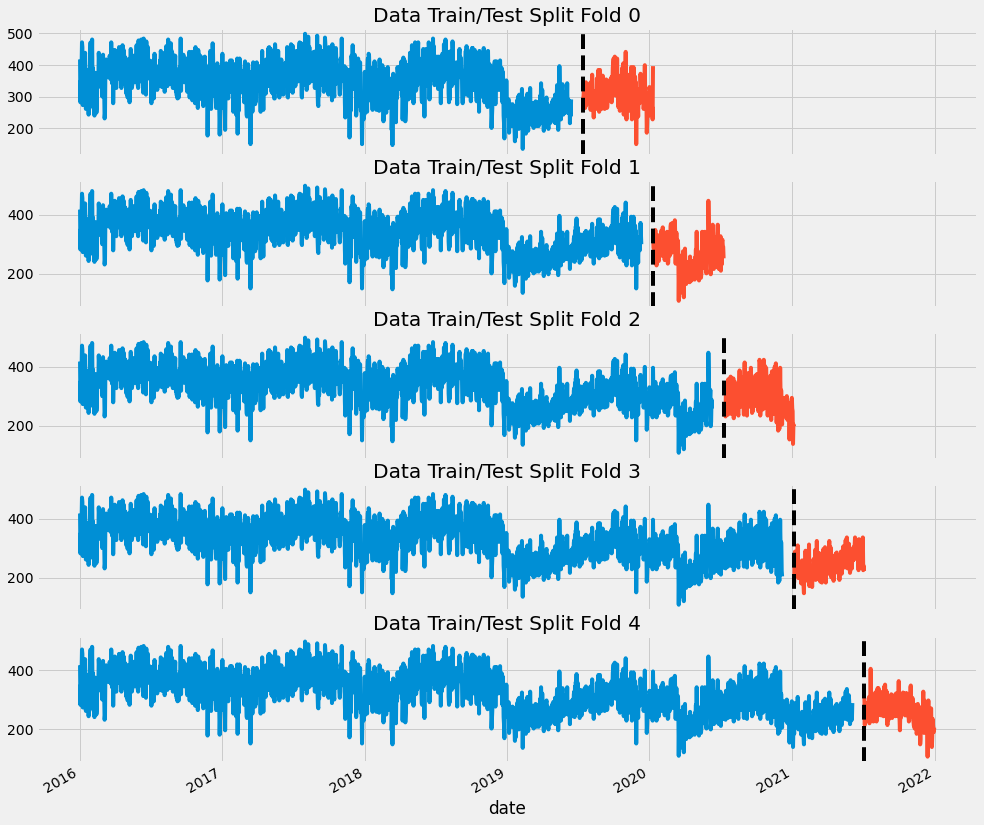

In [289]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Frequency'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Frequency'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [290]:
#forecasting
#feature creation
def create_feature(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df 
df = create_feature(df)



In [291]:
#lag features
target_map = df['Frequency'].to_dict()

In [292]:
def add_lags(df):
    target_map = df['Frequency'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df

In [293]:
df = add_lags(df)

In [294]:
#train use cross validation
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Frequency'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gblinear',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:47:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:326.80673	validation_1-rmse:288.42151


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:85.21008	validation_1-rmse:78.29242
[200]	validation_0-rmse:79.09574	validation_1-rmse:69.72031
[300]	validation_0-rmse:75.19003	validation_1-rmse:64.22215
[400]	validation_0-rmse:72.56219	validation_1-rmse:60.68795
[500]	validation_0-rmse:70.69859	validation_1-rmse:58.39354
[600]	validation_0-rmse:69.31283	validation_1-rmse:56.90993
[700]	validation_0-rmse:68.24033	validation_1-rmse:55.96372
[800]	validation_0-rmse:67.38241	validation_1-rmse:55.38464
[900]	validation_0-rmse:66.67881	validation_1-rmse:55.06065
[999]	validation_0-rmse:66.09570	validation_1-rmse:54.91405
[15:47:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:83.19273	validation_1-rmse:64.96454
[200]	validation_0-rmse:77.36257	validation_1-rmse:65.83862
[300]	validation_0-rmse:73.54456	validation_1-rmse:67.49621
[400]	validation_0-rmse:70.95461	validation_1-rmse:69.24498
[500]	validation_0-rmse:69.12591	validation_1-rmse:70.84088
[600]	validation_0-rmse:67.78199	validation_1-rmse:72.21635
[700]	validation_0-rmse:66.75687	validation_1-rmse:73.37901
[800]	validation_0-rmse:65.94923	validation_1-rmse:74.35834
[900]	validation_0-rmse:65.29505	validation_1-rmse:75.18748
[999]	validation_0-rmse:64.75817	validation_1-rmse:75.88592
[15:47:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:82.34857	validation_1-rmse:85.24660
[200]	validation_0-rmse:77.06776	validation_1-rmse:77.86262
[300]	validation_0-rmse:73.78262	validation_1-rmse:73.09907
[400]	validation_0-rmse:71.63522	validation_1-rmse:69.98094
[500]	validation_0-rmse:70.15326	validation_1-rmse:67.93040
[600]	validation_0-rmse:69.07701	validation_1-rmse:66.55634
[700]	validation_0-rmse:68.25842	validation_1-rmse:65.65041
[800]	validation_0-rmse:67.61149	validation_1-rmse:65.05444
[900]	validation_0-rmse:67.08414	validation_1-rmse:64.68144
[999]	validation_0-rmse:66.64787	validation_1-rmse:64.46684
[15:47:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:81.29763	validation_1-rmse:44.98658
[200]	validation_0-rmse:76.19689	validation_1-rmse:47.50963
[300]	validation_0-rmse:72.95779	validation_1-rmse:50.29164
[400]	validation_0-rmse:70.82323	validation_1-rmse:52.76465
[500]	validation_0-rmse:69.35480	validation_1-rmse:54.80675
[600]	validation_0-rmse:68.29855	validation_1-rmse:56.46927
[700]	validation_0-rmse:67.50573	validation_1-rmse:57.81156
[800]	validation_0-rmse:66.88707	validation_1-rmse:58.91094
[900]	validation_0-rmse:66.38881	validation_1-rmse:59.81637
[999]	validation_0-rmse:65.98094	validation_1-rmse:60.56906
[15:47:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:80.09931	validation_1-rmse:89.27193
[200]	validation_0-rmse:75.39492	validation_1-rmse:80.25307
[300]	validation_0-rmse:72.49465	validation_1-rmse:74.25245
[400]	validation_0-rmse:70.62444	validation_1-rmse:70.31461
[500]	validation_0-rmse:69.35580	validation_1-rmse:67.77277
[600]	validation_0-rmse:68.45173	validation_1-rmse:66.15674
[700]	validation_0-rmse:67.77636	validation_1-rmse:65.16839
[800]	validation_0-rmse:67.25073	validation_1-rmse:64.60341
[900]	validation_0-rmse:66.82769	validation_1-rmse:64.32002
[999]	validation_0-rmse:66.48107	validation_1-rmse:64.22591


In [295]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 64.0124
Fold scores:[54.914052352290675, 75.88592156613274, 64.46684339237673, 60.56906130183037, 64.22591347205763]


In [296]:
#predict the future
# Retrain on all data
df = create_feature(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Frequency'

X_all = df[FEATURES]
y_all = df['Frequency']

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=3200,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:47:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:322.00015


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:125.68362
[200]	validation_0-rmse:60.32893
[300]	validation_0-rmse:42.75805
[400]	validation_0-rmse:38.55093
[500]	validation_0-rmse:37.10387
[600]	validation_0-rmse:36.24827
[700]	validation_0-rmse:35.66613
[800]	validation_0-rmse:35.17449
[900]	validation_0-rmse:34.51844
[1000]	validation_0-rmse:33.56011
[1100]	validation_0-rmse:32.73251
[1200]	validation_0-rmse:32.14463
[1300]	validation_0-rmse:31.55619
[1400]	validation_0-rmse:30.98880
[1500]	validation_0-rmse:30.20910
[1600]	validation_0-rmse:29.54256
[1700]	validation_0-rmse:29.00403
[1800]	validation_0-rmse:28.24597
[1900]	validation_0-rmse:27.61753
[2000]	validation_0-rmse:27.05303
[2100]	validation_0-rmse:26.64044
[2200]	validation_0-rmse:26.15608
[2300]	validation_0-rmse:25.56886
[2400]	validation_0-rmse:25.12292
[2500]	validation_0-rmse:24.60739
[2600]	validation_0-rmse:24.04899
[2700]	validation_0-rmse:23.61164
[2800]	validation_0-rmse:23.15972
[2900]	validation_0-rmse:22.69713
[3000]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3200, n_jobs=10,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [297]:
#test the sample data
test_data = X_all.loc[X_all.index>= '01-01-2021']
test_data['prediction'] = reg.predict(test_data)

test_data

/var/folders/fr/0_7xr4pj1yb9zdvs7vk07dd80000gn/T/ipykernel_14649/2996367306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = reg.predict(test_data)


,dayofyear,dayofweek,quarter,month,year,lag1,lag2,lag3,prediction
date,,,,,,,,,
2021-01-01,1,4,1,1,2021,312.0,309.0,375.0,263.166992
2021-01-02,2,5,1,1,2021,321.0,249.0,264.0,244.369705
2021-01-03,3,6,1,1,2021,318.0,297.0,294.0,133.130905
2021-01-04,4,0,1,1,2021,222.0,291.0,249.0,205.402161
2021-01-05,5,1,1,1,2021,204.0,369.0,249.0,198.306091
...,...,...,...,...,...,...,...,...,...
2021-12-27,361,0,4,12,2021,273.0,228.0,282.0,229.435791
2021-12-28,362,1,4,12,2021,225.0,300.0,243.0,216.314560
2021-12-29,363,2,4,12,2021,273.0,249.0,303.0,213.819550


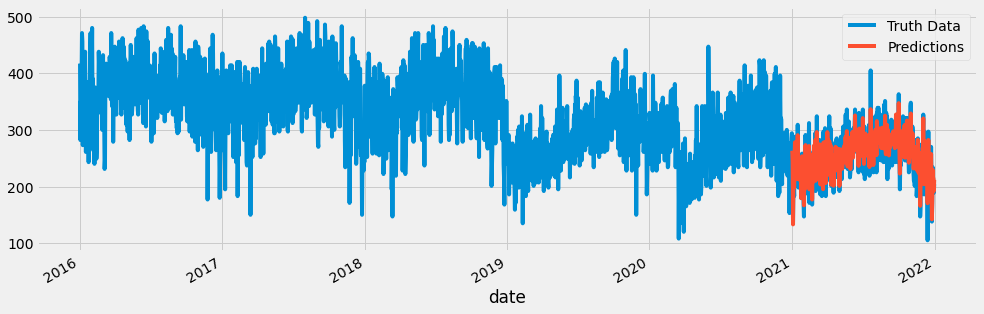

In [298]:
#plot the prediction from sample data
ax = df[['Frequency']].plot(figsize=(15, 5))
test_data['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])

In [299]:
#r2 score
from sklearn.metrics import r2_score
score_data = df.loc[df.index>= '01-01-2021']

r2_score(score_data["Frequency"],test_data["prediction"])

0.8126984926615225

In [317]:
#mean square error
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(score_data["Frequency"],test_data["prediction"]))
print("RMSE: ", rms)

RMSE:  18.43698467621026


In [300]:
df.index.max()


Timestamp('2021-12-31 00:00:00')

In [301]:
#create future data
future = pd.date_range('2022-01-01','2022-12-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [302]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,Frequency,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture
2022-01-01,NaN,2022,1,1,5,1,1,264.0,258.0,237.0,True
2022-01-02,NaN,2022,1,2,6,1,2,327.0,276.0,195.0,True
2022-01-03,NaN,2022,1,3,0,1,3,213.0,243.0,243.0,True
2022-01-04,NaN,2022,1,4,1,1,4,186.0,306.0,237.0,True
2022-01-05,NaN,2022,1,5,2,1,5,297.0,297.0,306.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,2022,12,27,1,4,361,NaN,NaN,NaN,True
2022-12-28,NaN,2022,12,28,2,4,362,NaN,NaN,NaN,True
2022-12-29,NaN,2022,12,29,3,4,363,NaN,NaN,NaN,True
2022-12-30,NaN,2022,12,30,4,4,364,NaN,NaN,NaN,True


In [303]:
#predict future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


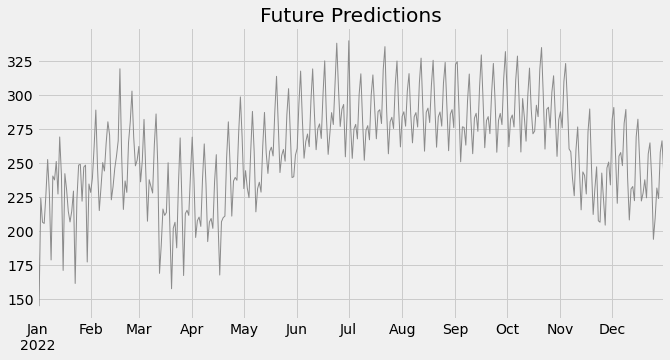

In [304]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [305]:
del future_w_features['Frequency']
future_w_features = future_w_features.rename(columns={'pred':'Frequency'})





In [306]:
future_w_features

,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture,Frequency
2022-01-01,2022,1,1,5,1,1,264.0,258.0,237.0,True,269.552216
2022-01-02,2022,1,2,6,1,2,327.0,276.0,195.0,True,144.867950
2022-01-03,2022,1,3,0,1,3,213.0,243.0,243.0,True,223.913254
2022-01-04,2022,1,4,1,1,4,186.0,306.0,237.0,True,206.313293
2022-01-05,2022,1,5,2,1,5,297.0,297.0,306.0,True,205.443832
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022,12,27,1,4,361,NaN,NaN,NaN,True,231.493561
2022-12-28,2022,12,28,2,4,362,NaN,NaN,NaN,True,223.742096
2022-12-29,2022,12,29,3,4,363,NaN,NaN,NaN,True,257.757355
2022-12-30,2022,12,30,4,4,364,NaN,NaN,NaN,True,266.180176


In [307]:
#merge future_w_features and df
final_data = pd.concat([df, future_w_features])
final_data = final_data['Frequency']
final_data


2016-01-02    417.000000
2016-01-03    282.000000
2016-01-04    351.000000
2016-01-05    345.000000
2016-01-06    396.000000
                 ...    
2022-12-27    231.493561
2022-12-28    223.742096
2022-12-29    257.757355
2022-12-30    266.180176
2022-12-31    242.339279
Name: Frequency, Length: 2547, dtype: float64

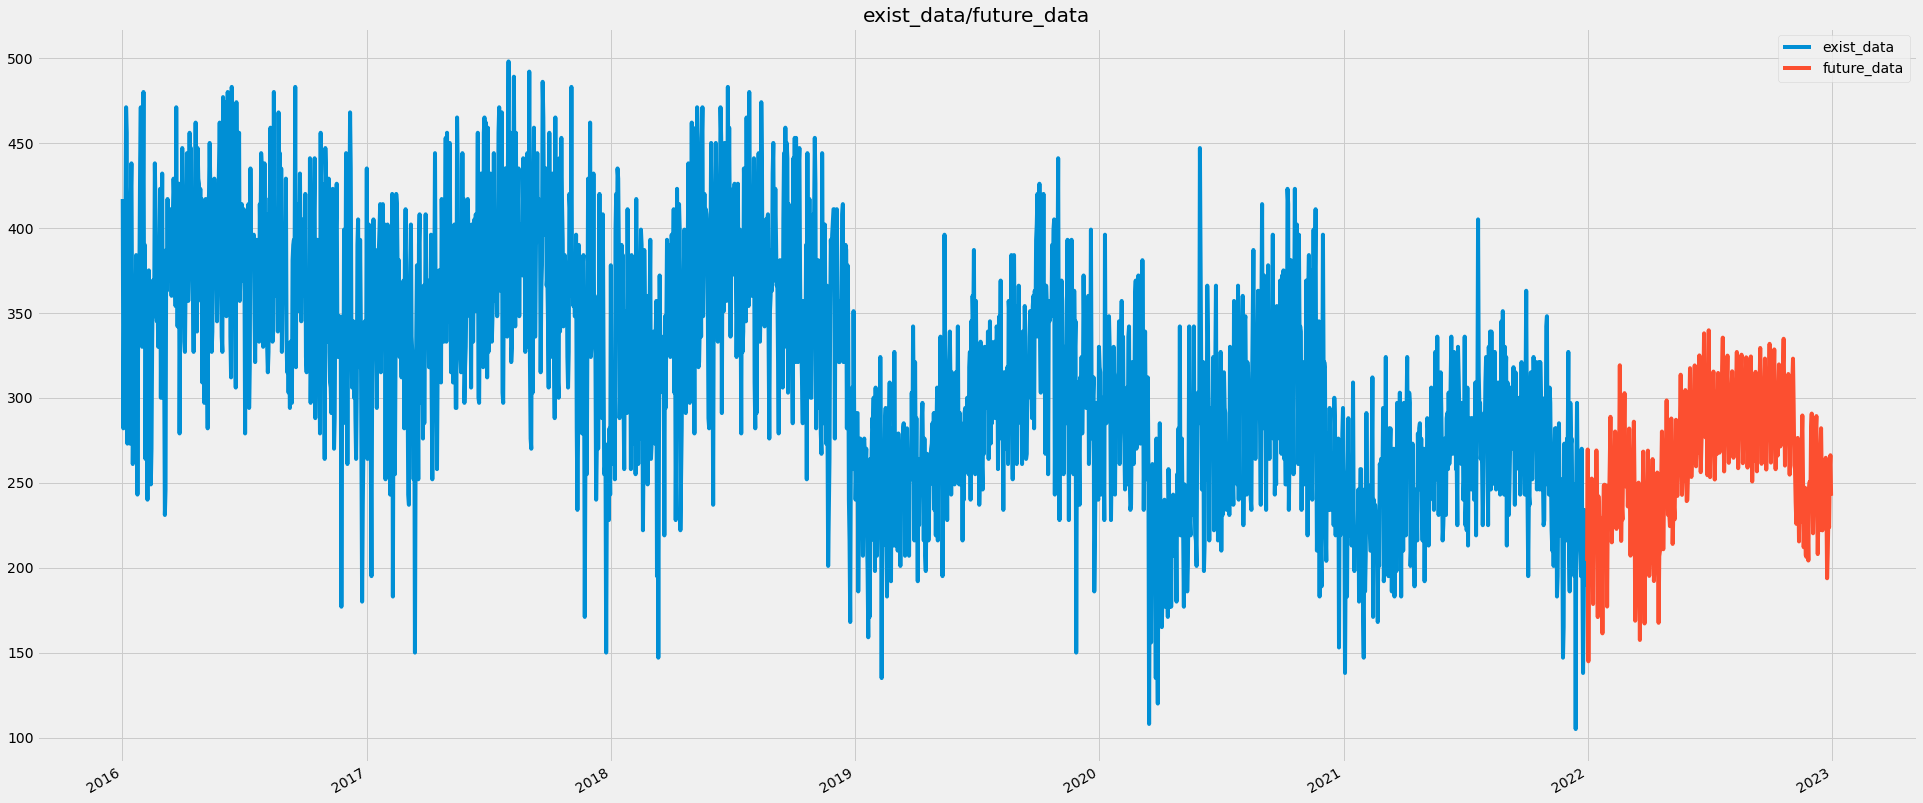

In [308]:
#plot the exist data with future data
exist_data = final_data.loc[final_data.index<'12-31-2021']
future_data = final_data.loc[final_data.index>='12-31-2021']

fig, ax = plt.subplots(figsize=(30,15))
exist_data.plot(ax=ax,label="exist_data",title='exist_data/future_data')
future_data.plot(ax=ax,label='future_data')
ax.legend(['exist_data','future_data'])
plt.show()

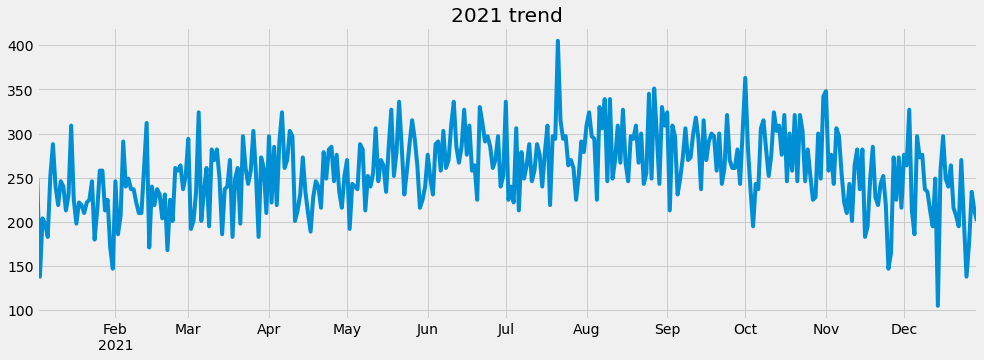

In [309]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2021') & (final_data.index<'12-30-2021')] \
.plot(figsize=(15,5),title="2021 trend")
plt.show()

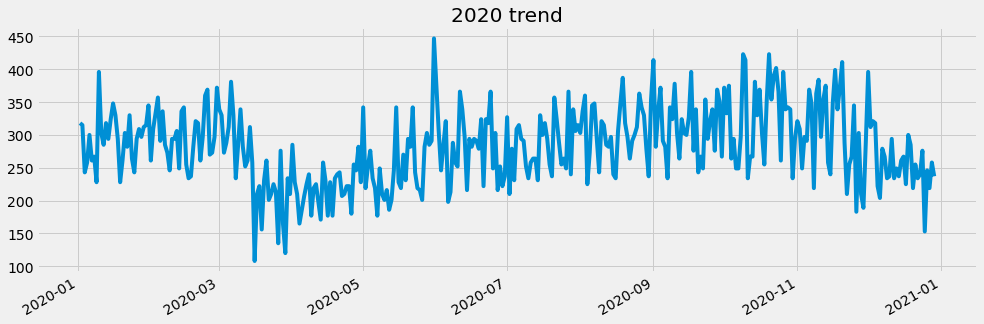

In [310]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2020') & (final_data.index<'12-30-2020')] \
.plot(figsize=(15,5),title="2020 trend")
plt.show()

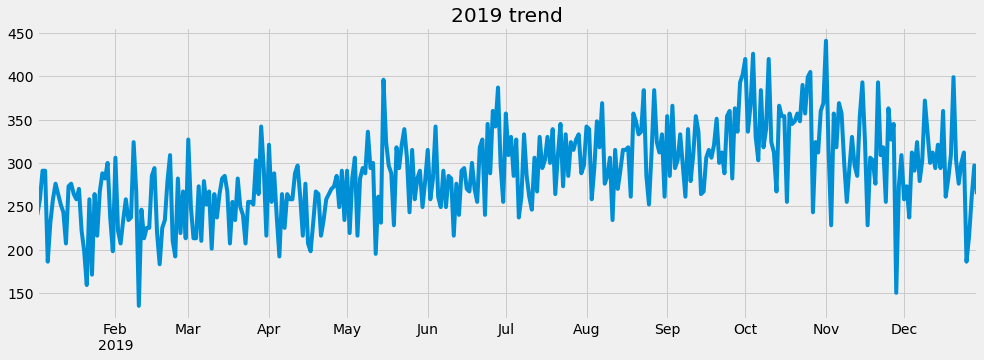

In [311]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2019') & (final_data.index<'12-30-2019')] \
.plot(figsize=(15,5),title="2019 trend")
plt.show()

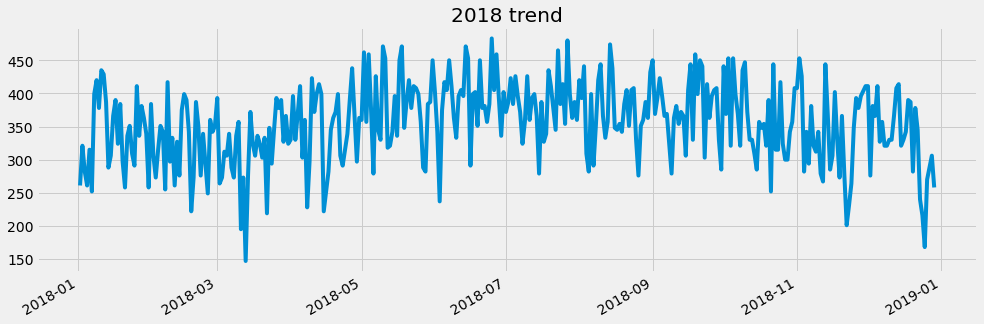

In [312]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2018') & (final_data.index<'12-30-2018')] \
.plot(figsize=(15,5),title="2018 trend")
plt.show()

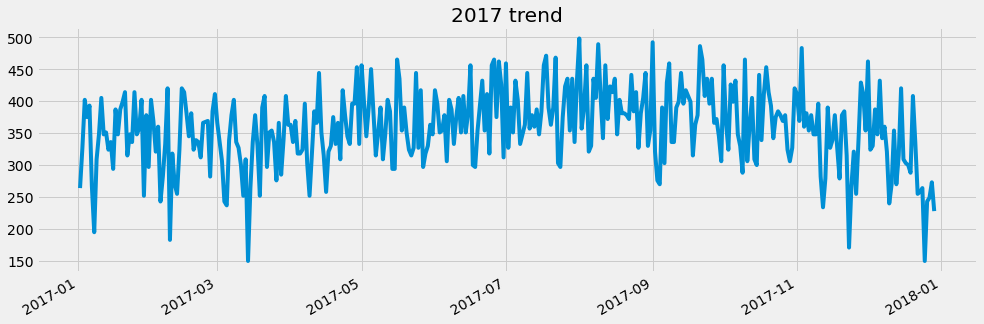

In [313]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2017') & (final_data.index<'12-30-2017')] \
.plot(figsize=(15,5),title="2017 trend")
plt.show()

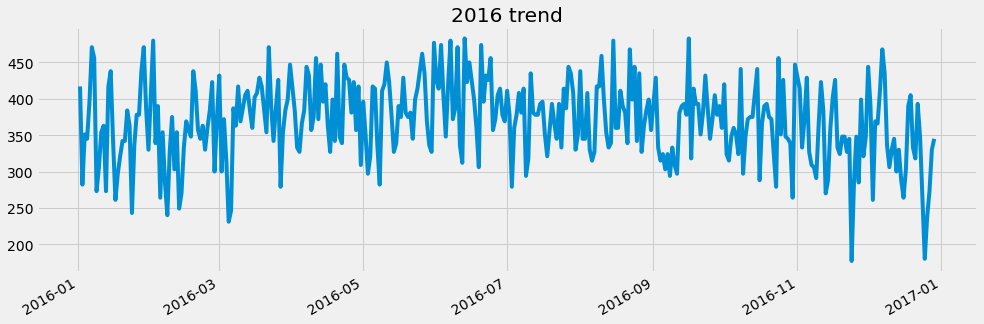

In [314]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2016') & (final_data.index<'12-30-2016')] \
.plot(figsize=(15,5),title="2016 trend")
plt.show()

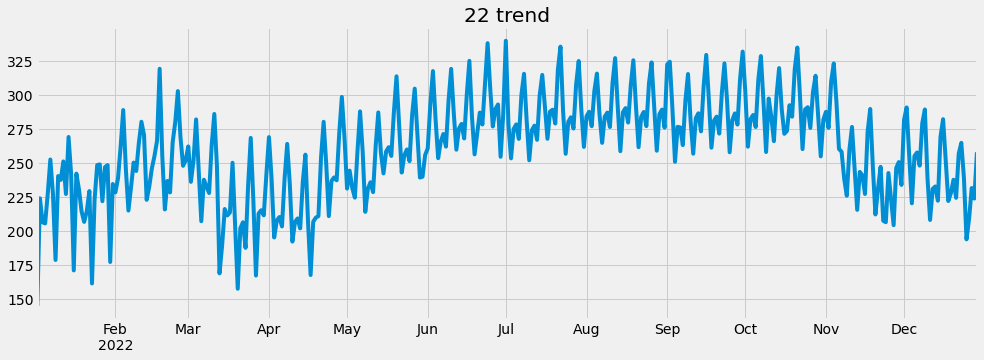

In [315]:
#check yearly trend
final_data.loc[(final_data.index>'01-01-2022') & (final_data.index<'12-30-2022')] \
.plot(figsize=(15,5),title="22 trend")
plt.show()